In [76]:
import numpy as np
from scipy.fft import fft2, ifft2
from tqdm import tqdm
import h5py
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
from numba import jit
name = "debug6"
n = 8
T = 10
w0 = 1
j0 = 1
method = 'IF'
eta = 1e-3
nu = 1e-3
CFL = 0.1


In [77]:
def gradient (data, h): # WARNING! This is not being used in this code!!
    derivative_grid = np.zeros(shape = (2,) + data.shape)

    #Doing x derivative
    derivative_grid[0, 1:-1, : ] = (data[2:,:] - data[:-2, :]) / (2*h) #interior points: central differences
    derivative_grid[0, 0 , : , ] = (data[1,:] - data[0, :]) / (h) #left edge, forward differences
    derivative_grid[0, -1 , : ,] = (data[-1,:] - data[-2,:]) / (h) #right edge, backward differences
    
    #Doing y derivative
    derivative_grid[1, : , 1:-1] = (data[:, 2:] - data[:, :-2]) / (2*h) #interior points: central differences
    derivative_grid[1, : , 0 ] = (data[:, 1] - data[:, 0]) / (h) #bottom edge, forward differences
    derivative_grid[1, : , -1 ] = (data[:, -1] - data[:, -2]) / (h) #top edge, backward differences

    return derivative_grid

@jit(nopython=True)
def laplacian_2d(field, dx):
    laplacian = np.zeros_like(field)
    dx2 = dx ** 2

    # Computing Laplacian for interior points
    laplacian[1:-1, 1:-1] = (field[:-2, 1:-1] + field[2:, 1:-1] + field[1:-1, :-2] + field[1:-1, 2:] - 4 * field[1:-1,1:-1]) / dx2

    # Assuming reflective boundary conditions for simplicity
    # Top and bottom
    laplacian[0, 1:-1] = laplacian[1, 1:-1]
    laplacian[-1, 1:-1] = laplacian[-2, 1:-1]
    # Left and right
    laplacian[1:-1, 0] = laplacian[1:-1, 1]
    laplacian[1:-1, -1] = laplacian[1:-1, -2]
    # Corners
    laplacian[0, 0] = laplacian[1, 1]
    laplacian[-1, -1] = laplacian[-2, -2]
    laplacian[0, -1] = laplacian[1, -2]
    laplacian[-1, 0] = laplacian[-2, 1]

    return laplacian

def u_biotSavaart (w_k):
    a = 1j * k_perp * w_k
    return ifft2(np.divide(a, k2, out=np.zeros_like(a), where=k2!=0)).real
    
def B_biotSavaart (j_k):
    a = 1j * k_perp * j_k
    return ifft2(np.divide(a, k2, out=np.zeros_like(a), where=k2!=0)).real  

In [78]:
N = 2**n # 2**8 = 256
L = 2*np.pi #16*np.pi
x = np.linspace(0,L,N)
dx = x[1]-x[0]
X, Y = np.meshgrid(x, x)

nu = nu #viscosity
eta = eta #magnetic diffusivity
k0 = 5 / L #dominant k_mode, needed for B-type init cond.
# The Fourier variables
w_k = np.empty((N,N), dtype=np.complex64)
j_k = np.empty((N,N), dtype=np.complex64)

kx = np.fft.fftfreq(N, d=dx)*2*np.pi
ky = np.fft.fftfreq(N, d=dx)*2*np.pi
k = np.array(np.meshgrid(kx , ky ,indexing ='ij'), dtype=np.float32)
k_perp = np.array(np.meshgrid(-ky , kx ,indexing ='ij'), dtype=np.float32)
k2 = np.sum(k*k,axis=0, dtype=np.float32)
kmax_dealias = kx.max()*2.0/3.0 # The Nyquist mode
# Dealising matrix
dealias = np.array((np.abs(k[0]) < kmax_dealias )*(np.abs(k[1]) < kmax_dealias ),dtype =bool)

Time step = 0.001


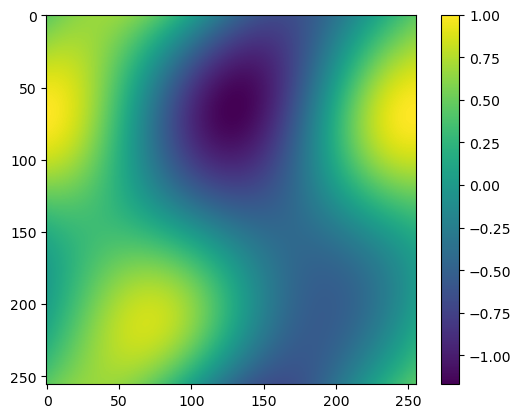

14004.414114147661
15515.159


In [80]:
"""
The different initial conditions used in the paper.
"""
stream_init_A1 = np.cos(X + 1.4) + np.cos(Y + 0.5)
flux_init_A1 = np.cos(2*X + 2.3) + np.cos(Y + 4.1)

stream_init_A2 = stream_init_A1.copy()
flux_init_A2 = flux_init_A1.copy() / 3

stream_init_B_k = np.exp(-k2/k0**2 + 1j*np.random.uniform(0, 2*np.pi, k2.shape))
flux_init_B_k = np.exp(-k2/k0**2 + 1j*np.random.uniform(0, 2*np.pi, k2.shape))

#stream_init_B_k /= np.sum(stream_init_B_k**2)
#flux_init_B_k /= np.sum(flux_init_B_k**2)

stream_init_B = ifft2(stream_init_B_k).real
flux_init_B = ifft2(flux_init_B_k).real

temp_w = laplacian_2d(stream_init_B, dx)
temp_w = w0 * temp_w / np.max(temp_w)
temp_wk = fft2(temp_w) # FT initial condition
u_init = u_biotSavaart (temp_wk)


# The time step definition
log10h = int(np.log10(CFL/(np.max(u_init[0])/dx + np.max(u_init[1])/dx))) - 1
h = 10**log10h
print("Time step = {}".format(h))

T = T
Nsteps = int (T /h)
dframes = h*10 # time step to output
Nframes = int (T/ dframes ) # frames to the output
nframes = Nsteps // Nframes

# The array of outputs (w: vorticity, j: current density)
w = np . empty (( Nframes ,N ,N) , dtype = np . float32 )
j = np . empty (( Nframes ,N ,N) , dtype = np . float32 )


w[0] = temp_w
w_k[:] = temp_wk 
Noperator_w_k = w_k.copy() # auxiliary array
ww = w[0].copy() # auxiliary array


j[0] = laplacian_2d(flux_init_B, dx)
j[0] = j0 * j[0] / np.max(j[0])
j_k[:] = fft2(j[0]) # FT initial condition
Noperator_j_k = j_k.copy() # auxiliary array
jj = j[0].copy() # auxiliary array

fig, ax = plt.subplots()
show = ax.imshow(j[0])
bar = plt.colorbar(show)
plt.show()

b = B_biotSavaart(j_k)
print(np.sum(u_init**2))
print(np.sum(b**2))

In [84]:
Loperator_w_k = -nu * k2
Loperator_j_k = -eta * k2

def Noperator_func_w_B (w_k, j_k):
    #Inverse fourier transform to real space
    w = ifft2(w_k).real 
    j = ifft2(j_k).real

    #Gradients in done in fft space 
    grad_w = ifft2(w_k * k).real #gradient(w, dx)
    grad_j = ifft2(j_k * k).real #gradient(j, dx)
    """
    shw = plt.imshow(grad_w[0] - grad_w_real[0])
    plt.colorbar(shw)
    """
    #Biot Savaart's law to find u and B 
    u = u_biotSavaart (w_k)   
    B = B_biotSavaart (j_k)

    #Non linear terms for the w_k evolution 
    B_dot_grad_j = B[0,:,:] * grad_j[0,:,:] + B[1,:,:] * grad_j[1,:,:]
    u_dot_grad_w = u[0,:,:] * grad_w[0,:,:] + u[1,:,:] * grad_w[1,:,:]
    
    #Non linear terms for the j_k evolution 
    B_cross_u = np.cross(B, u, axis = 0)
    lap_B_cross_u = laplacian_2d(B_cross_u, dx)    
    

    Noperator_func_w = fft2(B_dot_grad_j - u_dot_grad_w) 
    Noperator_func_j = fft2(lap_B_cross_u) 

    print(np.sum((grad_w)**2))
    print(np.sum((grad_j)**2))

    return (Noperator_func_w, Noperator_func_j)
Noperator_func_w_B (w_k, j_k)



12.71113
14.499399


(array([[-7.8007579e-06-0.00000000e+00j, -4.9471855e-06-1.01249665e-04j,
         -2.9621413e-05-5.23668714e-05j, ...,
         -2.4205816e-05+9.53139679e-05j, -2.9621413e-05+5.23668714e-05j,
         -4.9471855e-06+1.01249665e-04j],
        [-3.9100647e-05-3.03268433e-04j, -5.3405762e-05+2.49862671e-04j,
          4.2533875e-04-2.38418579e-04j, ...,
          6.8068504e-05+1.49369240e-04j, -3.6430359e-04+6.29425049e-05j,
          4.0054321e-05+5.76019287e-04j],
        [ 1.4722347e-05-1.28030777e-04j, -1.9073486e-06+2.47955322e-04j,
          3.8668513e-04-1.54435635e-04j, ...,
         -2.8781127e-05+1.15253031e-04j, -3.8398802e-04-2.92062759e-06j,
         -5.2928925e-05+4.81128693e-04j],
        ...,
        [ 4.5568944e-05+1.83127704e-04j, -1.3172510e-05-4.24323662e-04j,
         -3.7135131e-04+7.46131991e-05j, ...,
         -9.8481814e-07+8.10199617e-06j,  3.2669373e-04+5.49966790e-05j,
         -1.7198035e-06-4.01782861e-04j],
        [ 1.4722347e-05+1.28030777e-04j, -5.2928925

In [73]:
# Defining the time marching operators arrays

Tlinear_w_k = 0
Tnon_w_k = 0
Tlinear_j_k = 0 
Tnon_j_k = 0

if method == 'IMEX':
    Tlinear_w_k = 1.0/(1.0-h*Loperator_w_k) 
    Tnon_w_k = dealias*h/(1.0-h*Loperator_w_k)
    Tlinear_j_k = 1.0/(1.0-h*Loperator_j_k) 
    Tnon_j_k = dealias*h/(1.0-h*Loperator_j_k)
elif method == 'IF':
    Tlinear_w_k = np.exp(h*Loperator_w_k) 
    Tnon_w_k = dealias*h*Tlinear_w_k
    Tlinear_j_k = np.exp(h*Loperator_j_k) 
    Tnon_j_k = dealias*h*Tlinear_j_k
elif method == 'ETD':
    Tlinear_w_k = np.exp(h*Loperator_w_k) 
    Tlinear_j_k = np.exp(h*Loperator_j_k)
    def myexp(x):
        if x == 1: return 1.0
        else: return (x-1.0)/np.log(x)
    vmyexp = np.vectorize(myexp) # vectorize myexp (could be jitted)
    Tnon_w_k = dealias*h*vmyexp(Tlinear_w_k)
    Tnon_j_k = dealias*h*vmyexp(Tlinear_j_k)
else: print('ERROR: Undefined Integrator')


In [74]:
test_name = name
with h5py.File('sim_data_' + test_name + '.hdf5', 'w') as f:
    max_shape = (None,) + temp_w.shape  # None indicates an extendable dimension
    w_dataset = f.create_dataset('w', shape=(0,) + temp_w.shape, maxshape=max_shape)
    j_dataset = f.create_dataset('j', shape=(0,) + temp_w.shape, maxshape=max_shape)
    
    frame_counter = 0
    for i in tqdm(range(1, Nsteps)):
        # calculate the nonlinear operator (with dealising)
        Noperator_w_k, Noperator_j_k = Noperator_func_w_B(w_k, j_k)
        # updating in time
        w_k, j_k = w_k * Tlinear_w_k + Noperator_w_k * Tnon_w_k, j_k * Tlinear_j_k + Noperator_j_k * Tnon_j_k 
        # IFT to next step
        ww = ifft2(w_k).real
        jj = ifft2(j_k).real

        if (i % nframes) == 0:
            # Resize the dataset to accommodate the new data
            w_dataset.resize(frame_counter + 1, axis=0)
            j_dataset.resize(frame_counter + 1, axis=0)

            # Append the new frames
            w_dataset[frame_counter] = ww
            j_dataset[frame_counter] = jj

            frame_counter += 1
            f.flush()


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9999/9999 [01:28<00:00, 113.18it/s]


Error in callback <function _draw_all_if_interactive at 0x77e33992d260> (for post_execute), with arguments args (),kwargs {}:


ValueError: Dset_id is not a dataset id (dset_id is not a dataset ID)

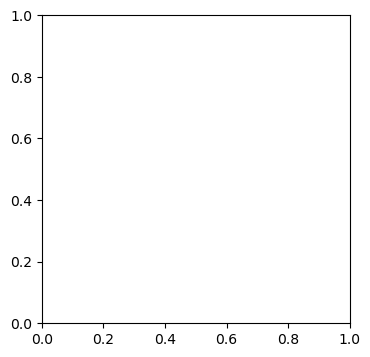

In [67]:
with h5py.File('sim_data_' + test_name + '.hdf5', 'r') as f:
    # Access the datasets
    w_dataset = f['w']
    j_dataset = f['j']
    Nframes = w_dataset.shape[0]  # Assuming the first dimension is time/frames
    t = np.linspace(0.0, Nsteps * h, Nframes)

    # Setup for animation
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    writervideo = animation.FFMpegWriter(fps = Nframes // T)


    # Function to animate vorticity
    def animate_w(i):
        ax.clear()
        ax.imshow(w_dataset[i], cmap='RdBu_r')
        ax.text(190, 20, 't={:.0f}'.format(t[i]), bbox=dict(boxstyle="round", ec='white', fc='white'))
        ax.set_xticks([])
        ax.set_yticks([])
        return fig,


    # Function to animate current density
    def animate_j(i):
        ax.clear()
        ax.imshow(j_dataset[i], cmap='RdBu_r')
        ax.text(190, 20, 't={:.0f}'.format(t[i]), bbox=dict(boxstyle="round", ec='white', fc='white'))
        ax.set_xticks([])
        ax.set_yticks([])
        return fig,


    # Create and save the animations
    ani_w = animation.FuncAnimation(fig, animate_w, frames=Nframes, interval=10)
    ani_w.save('pseudoSpectraMHD_' + test_name + '_vorticity.mp4', writer=writervideo, dpi=200)

    ani_j = animation.FuncAnimation(fig, animate_j, frames=Nframes, interval=10)
    ani_j.save('pseudoSpectraMHD_' + test_name + '_current_density.mp4', writer=writervideo, dpi=200)
